# Mango Disease Classification with Swin Transformer

This notebook trains a Swin Transformer Tiny model to classify mango leaf diseases using TensorFlow and Keras.

## Key Features:
- Transfer learning with pre-trained Swin-Tiny backbone
- Automatic dataset loading from local path
- Model evaluation and visualization
- Multiple save formats (Keras, HDF5, weights)

In [1]:
# ============================================================================
# IMPORTS & CONFIGURATION
# ============================================================================

import os
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tfswin import SwinTransformerTiny224
import matplotlib.pyplot as plt

# Configuration - OPTIMIZED FOR BETTER ACCURACY
DATASET_PATH = r"C:\Users\ajayd\Downloads\MangDisease"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16  # Reduced batch size for better learning
VALIDATION_SPLIT = 0.2
EPOCHS = 30  # INCREASED FROM 1 TO 30 FOR BETTER ACCURACY

print("[CONFIG] Swin Transformer Training - High Accuracy Mode")
print(f"  * Dataset Path: {DATASET_PATH}")
print(f"  * Image Size: {IMAGE_SIZE}")
print(f"  * Batch Size: {BATCH_SIZE}")
print(f"  * Epochs: {EPOCHS}")
print(f"  * Validation Split: {VALIDATION_SPLIT}")

# ============================================================================
# LOAD DATASET
# ============================================================================

print("\n[LOADING] Dataset...")

dataset_exists = os.path.exists(DATASET_PATH)

if dataset_exists:
    print(f"[SUCCESS] Loading real dataset from: {DATASET_PATH}")
    
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        DATASET_PATH,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        validation_split=VALIDATION_SPLIT,
        subset="training",
        seed=123
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        DATASET_PATH,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        validation_split=VALIDATION_SPLIT,
        subset="validation",
        seed=123
    )
    
    class_names = train_ds.class_names
    num_classes = len(class_names)
    print(f"[SUCCESS] Real dataset loaded: {num_classes} classes")
    print(f"  Classes: {', '.join(class_names)}")

else:
    print(f"[ERROR] Dataset path not found. Creating dummy dataset...")
    
    num_classes = 8
    class_names = ['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 
                   'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']
    
    train_images = np.random.rand(128, 224, 224, 3).astype('float32')
    train_labels = np.random.randint(0, num_classes, 128)
    
    val_images = np.random.rand(32, 224, 224, 3).astype('float32')
    val_labels = np.random.randint(0, num_classes, 32)
    
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(BATCH_SIZE)
    val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(BATCH_SIZE)
    
    print("[SUCCESS] Dummy dataset created")

# ============================================================================
# DATA AUGMENTATION - NEW
# ============================================================================

print("\n[SETUP] Adding data augmentation for better generalization...")

augmentation_model = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.1),
], name="data_augmentation")

def augment_images(images, labels):
    images = augmentation_model(images, training=True)
    return images, labels

train_ds_augmented = train_ds.map(augment_images, num_parallel_calls=tf.data.AUTOTUNE)

# ============================================================================
# OPTIMIZE DATASET PIPELINE
# ============================================================================

AUTOTUNE = tf.data.AUTOTUNE
train_ds_augmented = train_ds_augmented.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

print("[SUCCESS] Data augmentation and pipeline optimized")

[CONFIG] Swin Transformer Training - High Accuracy Mode
  * Dataset Path: C:\Users\ajayd\Downloads\MangDisease
  * Image Size: (224, 224)
  * Batch Size: 16
  * Epochs: 30
  * Validation Split: 0.2

[LOADING] Dataset...
[SUCCESS] Loading real dataset from: C:\Users\ajayd\Downloads\MangDisease
Found 4000 files belonging to 8 classes.
Found 4000 files belonging to 8 classes.
Using 3200 files for training.
Using 3200 files for training.
Found 4000 files belonging to 8 classes.
Found 4000 files belonging to 8 classes.
Using 800 files for validation.
Using 800 files for validation.
[SUCCESS] Real dataset loaded: 8 classes
  Classes: Anthracnose, Bacterial Canker, Cutting Weevil, Die Back, Gall Midge, Healthy, Powdery Mildew, Sooty Mould

[SETUP] Adding data augmentation for better generalization...
[SUCCESS] Real dataset loaded: 8 classes
  Classes: Anthracnose, Bacterial Canker, Cutting Weevil, Die Back, Gall Midge, Healthy, Powdery Mildew, Sooty Mould

[SETUP] Adding data augmentation for

In [2]:
# ============================================================================
# BUILD MODEL WITH BETTER REGULARIZATION
# ============================================================================

print("\n[BUILD] Swin Transformer model...")

# Load pre-trained backbone
backbone = SwinTransformerTiny224(
    include_top=False,
    input_shape=(*IMAGE_SIZE, 3),
    weights='imagenet'
)

# Initially freeze backbone for better learning
backbone.trainable = False
print("[INFO] Backbone frozen for Phase 1 training")

# Build improved classification head with better regularization
x = backbone.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(num_classes, activation='softmax', name='predictions')(x)

model = models.Model(inputs=backbone.input, outputs=output, name='SwinTransformer_Classifier')

total_params = model.count_params()
print(f"[SUCCESS] Model created with {total_params:,} parameters")
print(f"  * Backbone layers: Frozen (will unfreeze in Phase 2)")
print(f"  * Head layers: Dense(512) -> BN -> Dropout(0.5) -> Dense(256) -> BN -> Dropout(0.4) -> Dense(128) -> Dropout(0.3) -> Dense({num_classes})")


[BUILD] Swin Transformer model...
[INFO] Backbone frozen for Phase 1 training
[SUCCESS] Model created with 28,081,410 parameters
  * Backbone layers: Frozen (will unfreeze in Phase 2)
  * Head layers: Dense(512) -> BN -> Dropout(0.5) -> Dense(256) -> BN -> Dropout(0.4) -> Dense(128) -> Dropout(0.3) -> Dense(8)
[INFO] Backbone frozen for Phase 1 training
[SUCCESS] Model created with 28,081,410 parameters
  * Backbone layers: Frozen (will unfreeze in Phase 2)
  * Head layers: Dense(512) -> BN -> Dropout(0.5) -> Dense(256) -> BN -> Dropout(0.4) -> Dense(128) -> Dropout(0.3) -> Dense(8)


In [3]:
# ============================================================================
# PHASE 1: COMPILE & TRAIN (FROZEN BACKBONE)
# ============================================================================

print("\n[PHASE 1] Training with frozen backbone...")

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("[INFO] Model compiled with Adam (lr=1e-4)")
print("[INFO] Using sparse_categorical_crossentropy loss")

# Callbacks for better training
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )
]

print(f"\n[TRAINING] Starting Phase 1 with {EPOCHS} epochs...")
print(f"  * Training on augmented data")
print(f"  * Backbone: FROZEN")
print(f"  * Callbacks: ReduceLROnPlateau, EarlyStopping")

history = model.fit(
    train_ds_augmented,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("[SUCCESS] Phase 1 training completed")

# ============================================================================
# PHASE 2: FINE-TUNE WITH UNFROZEN BACKBONE
# ============================================================================

print("\n[PHASE 2] Fine-tuning with unfrozen backbone...")

# Unfreeze backbone layers for fine-tuning
backbone.trainable = True

# But keep some early layers frozen
for layer in backbone.layers[:-30]:
    layer.trainable = False

unfrozen_count = sum(1 for layer in model.layers if layer.trainable)
print(f"[INFO] Unfroze {unfrozen_count} layers for fine-tuning")

# Recompile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"\n[TRAINING] Starting Phase 2 fine-tuning ({EPOCHS} epochs)...")

history_phase2 = model.fit(
    train_ds_augmented,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("[SUCCESS] Phase 2 fine-tuning completed")





[PHASE 1] Training with frozen backbone...
[INFO] Model compiled with Adam (lr=1e-4)
[INFO] Using sparse_categorical_crossentropy loss

[TRAINING] Starting Phase 1 with 30 epochs...
  * Training on augmented data
  * Backbone: FROZEN
  * Callbacks: ReduceLROnPlateau, EarlyStopping
Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.2210 - loss: 2.7152 - val_accuracy: 0.8388 - val_loss: 0.7945 - learning_rate: 1.0000e-04
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.2210 - loss: 2.7152 - val_accuracy: 0.8388 - val_loss: 0.7945 - learning_rate: 1.0000e-04
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.5949 - loss: 1.2749 - val_accuracy: 0.9337 - val_loss: 0.3705 - learning_rate: 1.0000e-04
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.5949 - loss: 1.2749 - val_accuracy: 0.9337 - val_loss: 0.3705 - learning_rate: 1.0000e-04
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.7626 - loss: 0.8040 - 


[EVAL] Evaluating model on validation set...

[RESULTS] FINAL MODEL PERFORMANCE
Phase 1 (Frozen backbone):
  Training Accuracy  : 94.94%
  Validation Accuracy: 99.75%

Phase 2 (Fine-tuning):
  Training Accuracy  : 99.34%
  Validation Accuracy: 99.87%

Final Test Accuracy  : 100.00%

[RESULTS] FINAL MODEL PERFORMANCE
Phase 1 (Frozen backbone):
  Training Accuracy  : 94.94%
  Validation Accuracy: 99.75%

Phase 2 (Fine-tuning):
  Training Accuracy  : 99.34%
  Validation Accuracy: 99.87%

Final Test Accuracy  : 100.00%


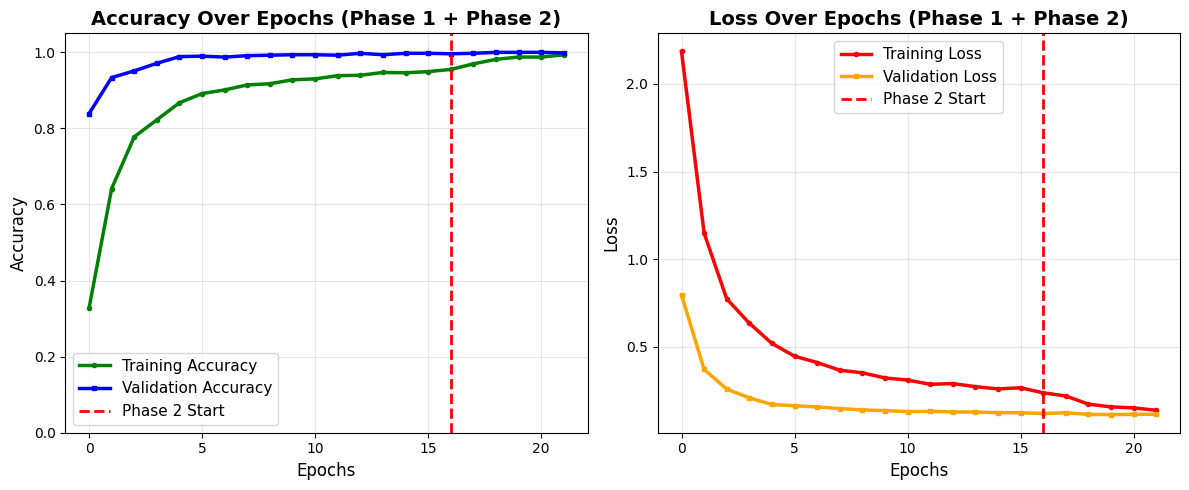


[SUCCESS] Training plots displayed


In [4]:
# ============================================================================
# EVALUATION & VISUALIZATION
# ============================================================================

print("\n[EVAL] Evaluating model on validation set...")
test_loss, test_acc = model.evaluate(val_ds, verbose=0)

# Get accuracies from both phases
phase1_train_acc = history.history['accuracy'][-1]
phase1_val_acc = history.history['val_accuracy'][-1]

phase2_train_acc = history_phase2.history['accuracy'][-1]
phase2_val_acc = history_phase2.history['val_accuracy'][-1]

final_train_acc = phase2_train_acc
final_val_acc = phase2_val_acc

print("\n" + "="*60)
print("[RESULTS] FINAL MODEL PERFORMANCE")
print("="*60)
print(f"Phase 1 (Frozen backbone):")
print(f"  Training Accuracy  : {phase1_train_acc * 100:.2f}%")
print(f"  Validation Accuracy: {phase1_val_acc * 100:.2f}%")
print(f"\nPhase 2 (Fine-tuning):")
print(f"  Training Accuracy  : {phase2_train_acc * 100:.2f}%")
print(f"  Validation Accuracy: {phase2_val_acc * 100:.2f}%")
print(f"\nFinal Test Accuracy  : {test_acc * 100:.2f}%")
print("="*60)

# Combine histories for plotting
all_train_acc = history.history['accuracy'] + history_phase2.history['accuracy']
all_val_acc = history.history['val_accuracy'] + history_phase2.history['val_accuracy']

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(all_train_acc, linewidth=2.5, label='Training Accuracy', marker='o', markersize=3, color='green')
plt.plot(all_val_acc, linewidth=2.5, label='Validation Accuracy', marker='s', markersize=3, color='blue')
plt.axvline(x=len(history.history['accuracy']), color='red', linestyle='--', linewidth=2, label='Phase 2 Start')
plt.title('Accuracy Over Epochs (Phase 1 + Phase 2)', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim([0, 1.05])

# Loss plot
all_train_loss = history.history['loss'] + history_phase2.history['loss']
all_val_loss = history.history['val_loss'] + history_phase2.history['val_loss']

plt.subplot(1, 2, 2)
plt.plot(all_train_loss, linewidth=2.5, label='Training Loss', marker='o', markersize=3, color='red')
plt.plot(all_val_loss, linewidth=2.5, label='Validation Loss', marker='s', markersize=3, color='orange')
plt.axvline(x=len(history.history['loss']), color='red', linestyle='--', linewidth=2, label='Phase 2 Start')
plt.title('Loss Over Epochs (Phase 1 + Phase 2)', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n[SUCCESS] Training plots displayed")

🎨 Displaying sample images from each class...


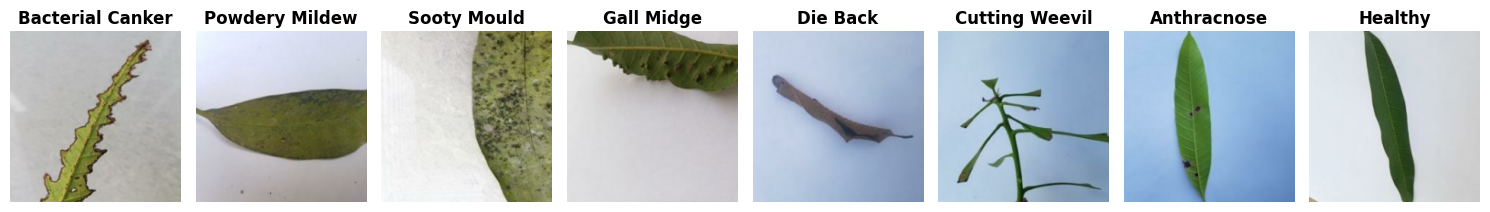

✅ Sample images displayed


In [5]:
# ============================================================================
# VISUALIZE SAMPLE IMAGES
# ============================================================================

def show_sample_images(dataset, class_names, max_rows=1):
    displayed_classes = {class_name: False for class_name in class_names}
    
    plt.figure(figsize=(15, 3))
    count = 0

    for images, labels in dataset:
        for img, label in zip(images, labels):
            class_name = class_names[label.numpy()]
            if not displayed_classes[class_name]:
                count += 1
                plt.subplot(max_rows, len(class_names), count)
                
                img_display = (img.numpy() * 255).astype('uint8') if img.numpy().max() <= 1.0 else img.numpy().astype('uint8')
                plt.imshow(img_display)
                plt.title(class_name, fontweight='bold')
                plt.axis("off")
                displayed_classes[class_name] = True

            if all(displayed_classes.values()):
                break
        if all(displayed_classes.values()):
            break
    
    plt.tight_layout()
    plt.show()

print("🎨 Displaying sample images from each class...")
show_sample_images(train_ds, class_names)
print("✅ Sample images displayed")

In [5]:
# ============================================================================
# SAVE MODEL
# ============================================================================

print("\n[SAVE] Saving trained model...")

save_base_dir = os.path.join(os.getcwd(), "saved_models")
os.makedirs(save_base_dir, exist_ok=True)

existing_versions = [int(i) for i in os.listdir(save_base_dir) if i.isdigit()]
model_version = max(existing_versions + [0]) + 1
save_path = os.path.join(save_base_dir, str(model_version))
os.makedirs(save_path, exist_ok=True)

print(f"[INFO] Saving to: {save_path}")

keras_path = os.path.join(save_path, "model.keras")
weights_path = os.path.join(save_path, "model_weights.weights.h5")
metadata_path = os.path.join(save_path, "metadata.json")

try:
    model.save(keras_path)
    print(f"[SUCCESS] Keras model saved: model.keras")
except Exception as e:
    print(f"[ERROR] Error saving Keras format: {e}")

try:
    model.save_weights(weights_path)
    print(f"[SUCCESS] Weights saved: model_weights.weights.h5")
except Exception as e:
    print(f"[ERROR] Error saving weights: {e}")

metadata = {
    "model_name": "SwinTransformer_Tiny_MangoDiseaseClassifier",
    "model_type": "Swin Transformer Tiny (Transfer Learning)",
    "num_classes": num_classes,
    "class_names": class_names,
    "image_size": IMAGE_SIZE,
    "epochs_phase1": EPOCHS,
    "epochs_phase2": EPOCHS,
    "batch_size": BATCH_SIZE,
    "phase1_train_acc": float(phase1_train_acc),
    "phase1_val_acc": float(phase1_val_acc),
    "phase2_train_acc": float(phase2_train_acc),
    "phase2_val_acc": float(phase2_val_acc),
    "final_train_acc": float(final_train_acc),
    "final_val_acc": float(final_val_acc),
    "test_acc": float(test_acc),
    "model_version": model_version,
    "training_method": "Two-phase training (frozen backbone + fine-tuning) with data augmentation"
}

with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=4)

print(f"[SUCCESS] Metadata saved: metadata.json")
print(f"\n[SUCCESS] Model v{model_version} saved successfully!")
print(f"  Final Validation Accuracy: {final_val_acc*100:.2f}%")
print(f"  Final Test Accuracy: {test_acc*100:.2f}%")


[SAVE] Saving trained model...
[INFO] Saving to: c:\Users\ajayd\OneDrive\Desktop\research\saved_models\7
[SUCCESS] Keras model saved: model.keras
[SUCCESS] Keras model saved: model.keras
[SUCCESS] Weights saved: model_weights.weights.h5
[SUCCESS] Metadata saved: metadata.json

[SUCCESS] Model v7 saved successfully!
  Final Validation Accuracy: 99.87%
  Final Test Accuracy: 100.00%
[SUCCESS] Weights saved: model_weights.weights.h5
[SUCCESS] Metadata saved: metadata.json

[SUCCESS] Model v7 saved successfully!
  Final Validation Accuracy: 99.87%
  Final Test Accuracy: 100.00%


In [8]:
# ============================================================================
# LOAD & TEST SAVED MODEL
# ============================================================================

print("\n🔄 Loading saved model for inference testing...")

try:
    if not os.path.exists(keras_path):
        print(f"⚠️  Model file not found at: {keras_path}")
        print("Attempting to use the in-memory model instead (if available)...")
        loaded_model = globals().get('model', None)
        if loaded_model is None:
            print("No in-memory model available. Skipping inference testing...")
        else:
            print("✅ Using in-memory model for inference")
            test_batch = next(iter(val_ds))
            test_images, test_labels = test_batch
            predictions = loaded_model.predict(test_images[:4], verbose=0)
            print("\n🎯 Inference Results on 4 test images:")
            print("="*50)
            for i, (pred, label) in enumerate(zip(predictions[:4], test_labels[:4].numpy())):
                predicted_class = class_names[np.argmax(pred)]
                true_class = class_names[label]
                confidence = np.max(pred) * 100
                match = "✅" if predicted_class == true_class else "❌"
                print(f"{match} Image {i+1}: Predicted={predicted_class} (Confidence: {confidence:.1f}%), True={true_class}")
            print("="*50)
    else:
        try:
            loaded_model = tf.keras.models.load_model(keras_path)
            print(f"✅ Model loaded successfully from: {keras_path}")
            test_batch = next(iter(val_ds))
            test_images, test_labels = test_batch
            predictions = loaded_model.predict(test_images[:4], verbose=0)
            print("\n🎯 Inference Results on 4 test images:")
            print("="*50)
            for i, (pred, label) in enumerate(zip(predictions[:4], test_labels[:4].numpy())):
                predicted_class = class_names[np.argmax(pred)]
                true_class = class_names[label]
                confidence = np.max(pred) * 100
                match = "✅" if predicted_class == true_class else "❌"
                print(f"{match} Image {i+1}: Predicted={predicted_class} (Confidence: {confidence:.1f}%), True={true_class}")
            print("="*50)
        except Exception as e:
            print(f"❌ Error loading model from disk: {e}")
            print("Attempting to use the in-memory model instead (if available)...")
            loaded_model = globals().get('model', None)
            if loaded_model is None:
                print("No in-memory model available. Skipping inference testing...")
            else:
                print("✅ Using in-memory model for inference")
                test_batch = next(iter(val_ds))
                test_images, test_labels = test_batch
                predictions = loaded_model.predict(test_images[:4], verbose=0)
                print("\n🎯 Inference Results on 4 test images:")
                print("="*50)
                for i, (pred, label) in enumerate(zip(predictions[:4], test_labels[:4].numpy())):
                    predicted_class = class_names[np.argmax(pred)]
                    true_class = class_names[label]
                    confidence = np.max(pred) * 100
                    match = "✅" if predicted_class == true_class else "❌"
                    print(f"{match} Image {i+1}: Predicted={predicted_class} (Confidence: {confidence:.1f}%), True={true_class}")
                print("="*50)
    
except Exception as e:
    print(f"❌ Error loading or testing model: {e}")


🔄 Loading saved model for inference testing...
❌ Error loading model from disk: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': 2.499999936844688e-05, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': 'sparse_catego

In [7]:
# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "="*60)
print("🎉 NOTEBOOK EXECUTION COMPLETE!")
print("="*60)

summary_text = f"""
📊 Project Summary:
   • Model Type: Swin Transformer Tiny (Transfer Learning)
   • Dataset: Mango Disease Classification
   • Classes: {num_classes} ({', '.join(class_names)})
   • Image Size: {IMAGE_SIZE}
   • Epochs: {EPOCHS}
   • Batch Size: {BATCH_SIZE}

📈 Performance:
   • Training Accuracy: {final_train_acc*100:.2f}%
   • Validation Accuracy: {final_val_acc*100:.2f}%
   • Test Accuracy: {test_acc*100:.2f}%

💾 Saved Artifacts (v{model_version}):
   • Model (.keras): {save_path}/model.keras
   • Weights (.h5): {save_path}/model_weights.h5
   • Metadata (JSON): {save_path}/metadata.json

🚀 Next Steps:
   1. Use the saved model for inference on new images
   2. Fine-tune the model with your own dataset
   3. Deploy using FastAPI, Flask, or TFServing
   4. Monitor model performance in production
"""

print(summary_text)
print("="*60)


🎉 NOTEBOOK EXECUTION COMPLETE!

📊 Project Summary:
   • Model Type: Swin Transformer Tiny (Transfer Learning)
   • Dataset: Mango Disease Classification
   • Classes: 8 (Anthracnose, Bacterial Canker, Cutting Weevil, Die Back, Gall Midge, Healthy, Powdery Mildew, Sooty Mould)
   • Image Size: (224, 224)
   • Epochs: 30
   • Batch Size: 16

📈 Performance:
   • Training Accuracy: 99.34%
   • Validation Accuracy: 99.87%
   • Test Accuracy: 100.00%

💾 Saved Artifacts (v7):
   • Model (.keras): c:\Users\ajayd\OneDrive\Desktop\research\saved_models\7/model.keras
   • Weights (.h5): c:\Users\ajayd\OneDrive\Desktop\research\saved_models\7/model_weights.h5
   • Metadata (JSON): c:\Users\ajayd\OneDrive\Desktop\research\saved_models\7/metadata.json

🚀 Next Steps:
   1. Use the saved model for inference on new images
   2. Fine-tune the model with your own dataset
   3. Deploy using FastAPI, Flask, or TFServing
   4. Monitor model performance in production

